In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('fivethirtyeight')
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from scipy import stats
from tqdm import tqdm_notebook as tqdm
import os

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
oof_path = './drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/'
sub_path = './drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission/'

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [0]:
def get_open_channels(file):
  df = pd.read_csv(file)
  return df['open_channels']

In [5]:
# load submission files
oof_df = pd.DataFrame()
sub_df = pd.DataFrame()
names = ['wavenet_iiyatu',  'lgbm_50hz', 'cat_rem50', 'ridge_rem50', 'xg_rem50', 'wavenet_earlystop']

for name in names:
  oof_name = 'oof_' + name
  oof_df[name] = get_open_channels(oof_path+oof_name+'.csv')
  sub_name = 'sub_' + name
  sub_df[name] = get_open_channels(sub_path+sub_name+'.csv')

sub_df

,wavenet_iiyatu,lgbm_50hz,cat_rem50,ridge_rem50,xg_rem50,wavenet_earlystop
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
1999995,0,0,0,0,0,0
1999996,0,0,0,0,0,0
1999997,0,0,0,0,0,0
1999998,0,0,0,0,0,0


In [6]:
  data = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/train_clean.csv')
  y = data["open_channels"]
  
  for name in oof_df.columns:
    f1 = metrics.f1_score(y, oof_df[name], average = 'macro')
    # list_score.append(f1)
    print(f' {name} oof macro f1 score is {f1}')

 wavenet_iiyatu oof macro f1 score is 0.9417301168675022
 lgbm_50hz oof macro f1 score is 0.9404759460880142
 cat_rem50 oof macro f1 score is 0.9405503882061665
 ridge_rem50 oof macro f1 score is 0.937621011766118
 xg_rem50 oof macro f1 score is 0.9343186300353724
 wavenet_earlystop oof macro f1 score is 0.9416549078426217


In [0]:
names = ['wavenet_saisin',  'wavenet_4', 'wavenet_5']

for name in names:
  oof_name = 'oof_' + name
  train_proba = np.load(oof_path+oof_name+'.npy')
  for i in range(11):
    oof_df[f"{name}_proba_{i}"] = train_proba[:, i]
  sub_name = 'sub_' + name
  test_proba = np.load(oof_path+sub_name+'.npy')
  for i in range(11):
    sub_df[f"{name}_proba_{i}"] = test_proba[:, i]

Y_train_proba = np.load(oof_path+"Y_train_proba.npy")
for i in range(11):
    oof_df[f"that_proba_{i}"] = Y_train_proba[:, i]
Y_test_proba = np.load(oof_path+"Y_test_proba.npy")
for i in range(11):
    sub_df[f"that_proba_{i}"] = Y_test_proba[:, i]

In [8]:
oof_df = reduce_mem_usage(oof_df)
sub_df = reduce_mem_usage(sub_df)
X = oof_df
tdf = sub_df
X

Mem. usage decreased from 1907.35 Mb to 448.23 Mb (76.5% reduction)
Mem. usage decreased from 762.94 Mb to 179.29 Mb (76.5% reduction)


,wavenet_iiyatu,lgbm_50hz,cat_rem50,ridge_rem50,xg_rem50,wavenet_earlystop,wavenet_saisin_proba_0,wavenet_saisin_proba_1,wavenet_saisin_proba_2,wavenet_saisin_proba_3,wavenet_saisin_proba_4,wavenet_saisin_proba_5,wavenet_saisin_proba_6,wavenet_saisin_proba_7,wavenet_saisin_proba_8,wavenet_saisin_proba_9,wavenet_saisin_proba_10,wavenet_4_proba_0,wavenet_4_proba_1,wavenet_4_proba_2,wavenet_4_proba_3,wavenet_4_proba_4,wavenet_4_proba_5,wavenet_4_proba_6,wavenet_4_proba_7,wavenet_4_proba_8,wavenet_4_proba_9,wavenet_4_proba_10,wavenet_5_proba_0,wavenet_5_proba_1,wavenet_5_proba_2,wavenet_5_proba_3,wavenet_5_proba_4,wavenet_5_proba_5,wavenet_5_proba_6,wavenet_5_proba_7,wavenet_5_proba_8,wavenet_5_proba_9,wavenet_5_proba_10,that_proba_0,that_proba_1,that_proba_2,that_proba_3,that_proba_4,that_proba_5,that_proba_6,that_proba_7,that_proba_8,that_proba_9,that_proba_10
0,0,0,0,0,0,0,9.985352e-01,1.802444e-04,0.000067,1.298189e-04,3.349781e-05,0.000008,0.000018,0.000046,0.000152,0.000421,0.000186,0.998535,7.853508e-04,8.034706e-05,4.571676e-05,1.686811e-05,9.059906e-06,0.000014,3.015995e-05,5.799532e-05,0.000080,0.000218,9.985352e-01,5.455017e-04,3.069639e-05,2.622604e-05,2.503395e-05,2.056360e-05,1.490116e-05,4.768372e-06,0.000023,3.725290e-05,0.000545,0.966797,0.028336,0.004810,0.000114,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,0,0,0,0,9.985352e-01,7.467270e-04,0.000073,8.410215e-05,1.043081e-05,0.000006,0.000024,0.000030,0.000061,0.000248,0.000186,0.999512,4.370213e-04,3.510714e-05,3.278255e-06,1.460314e-05,2.062321e-05,0.000020,1.889467e-05,3.117323e-05,0.000019,0.000026,9.995117e-01,3.085136e-04,4.351139e-06,3.874302e-06,2.443790e-06,1.668930e-06,1.966953e-06,4.172325e-07,0.000002,3.278255e-06,0.000044,0.996094,0.003466,0.000426,0.000063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,0,0,0,0,0,9.965820e-01,3.112793e-03,0.000010,3.159046e-06,1.847744e-06,0.000004,0.000025,0.000021,0.000011,0.000055,0.000058,0.999512,2.415180e-04,9.644032e-05,6.437302e-06,3.814697e-06,9.834766e-06,0.000024,1.156330e-05,1.168251e-05,0.000008,0.000017,9.892578e-01,8.857727e-03,4.607439e-05,2.131462e-04,1.358986e-03,1.266003e-04,2.026558e-05,1.621246e-05,0.000054,4.667044e-05,0.000204,0.976074,0.018982,0.004677,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,0,0,0,0,0,1.000000e+00,3.021955e-05,0.000001,4.172325e-07,8.940697e-07,0.000001,0.000002,0.000001,0.000001,0.000007,0.000009,1.000000,8.523464e-06,1.192093e-06,5.364418e-07,7.152557e-07,2.264977e-06,0.000008,4.589558e-06,4.529953e-06,0.000007,0.000011,1.000000e+00,2.920628e-06,4.768372e-07,3.159046e-06,6.556511e-07,1.192093e-07,3.576279e-07,1.788139e-07,0.000001,5.364418e-07,0.000003,0.996094,0.003626,0.000326,0.000046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,0,0,0,0,0,1.000000e+00,3.272295e-05,0.000001,2.980232e-07,1.907349e-06,0.000005,0.000004,0.000001,0.000002,0.000008,0.000017,1.000000,5.364418e-07,1.788139e-07,2.980232e-07,2.980232e-07,8.344650e-07,0.000002,8.940697e-07,8.940697e-07,0.000001,0.000002,1.000000e+00,4.768372e-07,7.748604e-07,8.225441e-06,7.987022e-06,6.556511e-07,2.384186e-06,4.768372e-07,0.000002,1.728535e-06,0.000010,0.997559,0.002335,0.000158,0.000042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,7,7,7,7,7,7,7.331371e-06,8.344650e-07,0.000021,2.193451e-05,2.384186e-07,0.000056,0.002735,0.986816,0.010345,0.000013,0.000010,0.000003,1.355410e-04,1.710653e-05,2.980232e-07,4.768372e-07,2.920628e-06,0.005470,9.838867e-01,1.055908e-02,0.000063,0.000011,2.384186e-07,9.834766e-06,1.370907e-06,1.907349e-06,3.039837e-06,2.348423e-05,2.059937e-02,9.770508e-01,0.002201,2.235174e-05,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.003376,0.078369,0.867188,0.0483

In [9]:

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
i=1;
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],1))

params = {'boosting_type': 'gbdt',
          'metric': 'rmse',
          'objective': 'regression',
          'n_jobs': -1,
          'seed': 236}
          # 'num_leaves': 280,
          # 'learning_rate': 0.026623466966581126,
          # 'max_depth': 73,
          # 'lambda_l1': 2.959759088169741,
          # 'lambda_l2': 1.331172832164913,
          # 'bagging_fraction': 0.9655406551472153,
          # 'bagging_freq': 9,
          # 'colsample_bytree': 0.6867118652742716}

oof_pred = np.zeros(len(X))
# y_pred = np.zeros(shape=(tdf.shape[0], 1))
y_pred = []
train_pred = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_valid, y_valid)
    
    model = lgb.train(params, train_set, num_boost_round = 5000, early_stopping_rounds = 100, 
                      valid_sets = [train_set, val_set], verbose_eval = 100)
    
    oof_pred[valid_index] = model.predict(X_valid)
    # y_pred += model.predict(tdf) / folds.n_splits
    y_pred.append(model.predict(tdf))
    train_pred.append(model.predict(X))
    # break
    
rmse_score = np.sqrt(metrics.mean_squared_error(y, oof_pred))
# want to clip and then round predictions (you can get a better performance using optimization to found the best cuts)
oof_pred = np.round(np.clip(oof_pred, 0, 10)).astype(int)
round_y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)
f1 = metrics.f1_score(y, oof_pred, average = 'macro')
print(f'Our oof rmse score is {rmse_score}')
print(f'Our oof macro f1 score is {f1}')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.145761	valid_1's rmse: 0.146378
[200]	training's rmse: 0.145014	valid_1's rmse: 0.14635
[300]	training's rmse: 0.144321	valid_1's rmse: 0.146331
Early stopping, best iteration is:
[274]	training's rmse: 0.144497	valid_1's rmse: 0.146326
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.145822	valid_1's rmse: 0.145984
[200]	training's rmse: 0.145105	valid_1's rmse: 0.145976
[300]	training's rmse: 0.144438	valid_1's rmse: 0.145979
Early stopping, best iteration is:
[247]	training's rmse: 0.144778	valid_1's rmse: 0.145967
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.145658	valid_1's rmse: 0.146682
[200]	training's rmse: 0.144928	valid_1's rmse: 0.146654
Early stopping, best iteration is:
[172]	training's rmse: 0.145109	valid_1's rmse: 0.14665
Training until validation scores don't improve for 100 rounds.
[100]	training's r

In [10]:

for i in range(len(y_pred)):
  if i == 0:
    predpred = y_pred[i] / folds.n_splits
  else:
    predpred += y_pred[i] / folds.n_splits

round_y_pred = np.round(np.clip(predpred, 0, 10)).astype(int)

submission = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission/sample_submission.csv')

submission['open_channels'] = round_y_pred
submission.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sub_9422_wav.csv', index = False, float_format='%.4f')
submission.head(20)

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
5,500.0006,0
6,500.0007,0
7,500.0008,0
8,500.0009,0
9,500.0010,0


In [9]:
!pip install tensorflow==1.14
from keras.models import Model
import keras.layers as L
import tensorflow as tf
tf.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

'1.14.0'

In [0]:
def create_mpl(shape):
    '''
    Returns a keras model
    '''
    
    X_input = L.Input(shape)
    
    X = L.Dense(150, activation='relu')(X_input)
    X = L.Dense(150, activation='relu')(X)
    X = L.Dense(125, activation='relu')(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dense(75, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(25, activation='relu')(X)
    X = L.Dense(11, activation='softmax')(X)

    # X = L.Dense(150, activation='LeakyReLU')(X_input)
    # X = L.Dense(150, activation='LeakyReLU')(X)
    # X = L.Dense(125, activation='LeakyReLU')(X)
    # X = L.Dense(75, activation='LeakyReLU')(X)
    # X = L.Dense(50, activation='LeakyReLU')(X)
    # X = L.Dense(25, activation='LeakyReLU')(X)
    # X = L.Dense(11, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model


In [0]:
def f1_score_calc(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

class_weight= [  4.03176385   5.07168831   9.02650905   7.47821223  12.39433827
  17.9935727   26.57990984  18.86685659  20.39293099  36.73229503
 139.92667842]


Text(0.5, 1.0, 'class_weight')

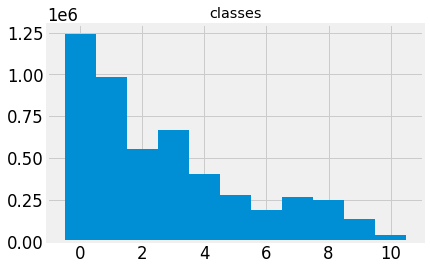

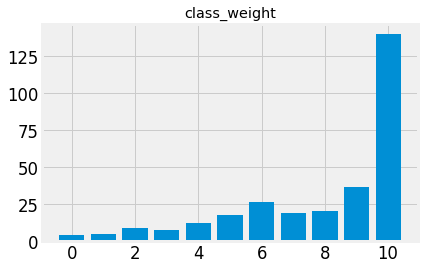

In [12]:
def get_class_weight(classes, exp=1):
    '''
    Weight of the class is inversely proportional to the population of the class.
    There is an exponent for adding more weight.
    '''
    hist, _ = np.histogram(classes, bins=np.arange(12)-0.5)
    class_weight = hist.sum()/np.power(hist, exp)
    
    return class_weight

class_weight = get_class_weight(y)
print('class_weight=', class_weight)
plt.figure()
plt.title('classes')
plt.hist(y, bins=np.arange(12)-0.5)
plt.figure()
plt.title('class_weight')
plt.bar(np.arange(11), class_weight)
plt.title('class_weight')

In [13]:
from sklearn.model_selection import StratifiedKFold
i=1;
n_fold = 4 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=17)
scores = []
oof_pred = np.zeros((len(X), 11))

prediction = np.zeros(shape=(tdf.shape[0],11))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print(i,"*******th fold**************")
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    mlp = create_mpl(X_train[0].shape)
    mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    mlp.fit(x=X_train, y=y_train, epochs=50, batch_size=1024, class_weight=class_weight)
    pred = mlp.predict(X_valid)
    oof_pred[valid_index] = pred
    pred = np.argmax(pred,axis=-1)
    score = f1_score_calc(y_valid, pred)
    print(score)
    #scores.append(score)
    y_pred = mlp.predict(tdf) 
    prediction += y_pred
    i = i+1

prediction /= n_fold
#print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))



1 *******th fold**************

Epoch 1/50
3750000/3750000 [==============================] - 72s 19us/step - loss: 0.0949 - sparse_categorical_accuracy: 0.9690
Epoch 2/50
3750000/3750000 [==============================] - 73s 20us/step - loss: 0.0786 - sparse_categorical_accuracy: 0.9709
Epoch 3/50
3750000/3750000 [==============================] - 74s 20us/step - loss: 0.0774 - sparse_categorical_accuracy: 0.9710
Epoch 4/50
3750000/3750000 [==============================] - 73s 19us/step - loss: 0.0768 - sparse_categorical_accuracy: 0.9711
Epoch 5/50
3750000/3750000 [==============================] - 74s 20us/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9711
Epoch 6/50
3750000/3750000 [==============================] - 74s 20us/step - loss: 0.0763 - sparse_categorical_accuracy: 0.9712
Epoch 7/50
3750000/3750000 [==============================] - 72s 19us/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9712
Epoch 8/50
3750000/3750000 [==============================] - 72s

In [0]:
np.save('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/oof_mlp_proba_scoreing.npy', oof_pred)
for i in range(len(y_pred)):
  if(i==0):
    round_y_pred = y_pred[i]
  else:
    round_y_pred += y_pred[i]
np.save('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/sub_mlp_proba_scoreing.npy', round_y_pred)

In [14]:
f1 = metrics.f1_score(y, np.argmax(oof_pred, axis=-1), average = 'macro')
f1

0.9420867826857738

In [19]:
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission/sample_submission.csv')
sub['open_channels'] =  np.argmax(round_y_pred, axis=-1)

sub.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission/scoreing_mlp.csv', index=False, float_format='%.4f')
sub.head(10)

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
5,500.0006,0
6,500.0007,0
7,500.0008,0
8,500.0009,0
9,500.0010,0


In [12]:

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
i=1;
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],1))

# params = {'boosting_type': 'gbdt',
#           'metric': 'rmse',
#           'objective': 'regression',
#           'n_jobs': -1,
#           'seed': 236}
#           # 'num_leaves': 280,
#           # 'learning_rate': 0.026623466966581126,
#           # 'max_depth': 73,
#           # 'lambda_l1': 2.959759088169741,
#           # 'lambda_l2': 1.331172832164913,
#           # 'bagging_fraction': 0.9655406551472153,
#           # 'bagging_freq': 9,
#           # 'colsample_bytree': 0.6867118652742716}

params = {
    'objective': 'multiclass',
    'num_class': 11,
    'metric': 'multi_logloss'}
    # 'learning_rate': 0.00987173774816051,
    # 'lambda_l1': 0.00031963798315506463,
    # 'lambda_l2': 0.18977456778807847,
    # 'num_leaves': 171, 
    # 'feature_fraction': 0.58733782457345, 
    # 'bagging_fraction': 0.7057826081907392, 
    # 'bagging_freq': 4}

oof_pred = np.zeros((len(X), 11))
# y_pred = np.zeros(shape=(tdf.shape[0], 1))
y_pred = []
train_pred = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_valid, y_valid)
    
    model = lgb.train(params, train_set, num_boost_round = 500, early_stopping_rounds = 30, 
                      valid_sets = [train_set, val_set], verbose_eval = 10)
    
    # oof_pred[valid_index] = model.predict(X_valid)
    gbc_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    oof_pred[valid_index] = gbc_pred
    # y_pred += model.predict(tdf) / folds.n_splits
    print(f1_score(y_valid, np.argmax(gbc_pred, axis=1), average='macro'))

    y_pred.append(model.predict(tdf, num_iteration=model.best_iteration))
    train_pred.append(model.predict(X, num_iteration=model.best_iteration))
    # break
    
rmse_score = np.sqrt(metrics.mean_squared_error(y, np.argmax(oof_pred, axis=1)))
# want to clip and then round predictions (you can get a better performance using optimization to found the best cuts)
# oof_pred = np.round(np.clip(oof_pred, 0, 10)).astype(int)
# round_y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)
f1 = metrics.f1_score(y, np.argmax(oof_pred, axis=1), average = 'macro')
print(f'Our oof rmse score is {rmse_score}')
print(f'Our oof macro f1 score is {f1}')



Training until validation scores don't improve for 30 rounds.
[10]	training's multi_logloss: 0.573777	valid_1's multi_logloss: 0.574401
[20]	training's multi_logloss: 0.253718	valid_1's multi_logloss: 0.254803
[30]	training's multi_logloss: 0.142524	valid_1's multi_logloss: 0.144114
[40]	training's multi_logloss: 0.100991	valid_1's multi_logloss: 0.103088
[50]	training's multi_logloss: 0.0843597	valid_1's multi_logloss: 0.0870747
[60]	training's multi_logloss: 0.0770716	valid_1's multi_logloss: 0.0804356
[70]	training's multi_logloss: 0.0735432	valid_1's multi_logloss: 0.0777897
[80]	training's multi_logloss: 0.0716089	valid_1's multi_logloss: 0.0765356
[90]	training's multi_logloss: 0.070883	valid_1's multi_logloss: 0.0763297
[100]	training's multi_logloss: 0.0709786	valid_1's multi_logloss: 0.0774875
[110]	training's multi_logloss: 0.0715036	valid_1's multi_logloss: 0.081236
[120]	training's multi_logloss: 0.0786979	valid_1's multi_logloss: 0.0915267
Early stopping, best iteration is

In [15]:
for i in range(len(y_pred)):
  if(i==0):
    round_y_pred = y_pred[i]
  else:
    round_y_pred += y_pred[i]
np.array(round_y_pred).shape

(11,)

In [0]:
np.save('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/sub_mlp_class_proba_scoreing.npy', y_pred)

In [18]:
oof_pred.shape

(5000000, 11)

In [0]:
np.save('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/data/oof_mlp_class_proba_scoreing.npy', oof_pred)